In [1]:
import numpy as np
import pandas as pd
from random import shuffle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
from torchvision import transforms, datasets, models
from train import train_model, train_loss, train_accuracy, val_loss, val_accuracy
from torchsummary import summary
import time
import copy
import seaborn as sns
sns.set(font_scale=1.4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 32


In [17]:
dataset = torch.load('../../datasets/64skulldataset.pt')

extraAD1 = torch.load('../../datasets/GAN_SS/64ADgan1SS.pt')
extraAD2 = torch.load('../../datasets/GAN_SS/64ADgan2SS.pt')
extraAD3 = torch.load('../../datasets/GAN_SS/64ADgan3SS.pt')

extraNC1 = torch.load('../../datasets/GAN_SS/64NCgan1SS.pt')
extraNC2 = torch.load('../../datasets/GAN_SS/64NCgan2SS.pt')
extraNC3 = torch.load('../../datasets/GAN_SS/64NCgan3SS.pt')

extraAD = [([extraAD1[j][0], extraAD2[j][0], extraAD3[j][0]], extraAD1[j][1]) 
              for j in tqdm(range(len(extraAD1))) ]
extraNC = [([extraNC1[j][0], extraNC2[j][0], extraNC3[j][0]], extraNC1[j][1]) 
              for j in tqdm(range(len(extraNC1))) ]

dataset = torch.utils.data.ConcatDataset((dataset, extraNC, extraAD))

lengths = [

    int(len(dataset) * 0.8),
    int(len(dataset) * 0.1),
    int(len(dataset) * 0.1) + 1
]


trainset, valset, testset = random_split(dataset, lengths)

# trainset = torch.utils.data.ConcatDataset((trainset, extraNC, extraAD))

image_datasets = {'train': trainset, 'val': valset, 'test': testset}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}  

In [3]:
class MultiCNN(nn.Module):
    def __init__(self):
        super(MultiCNN, self).__init__()
        self.fc1 = nn.Linear(6144, 256)
        self.fc2 = nn.Linear(256, 2)
        self.fc3 = nn.Linear(10, 2)
        resnet = models.resnet50(pretrained=True).to(device) 
        self.new_resnet1 = nn.Sequential(*list(resnet.children())[:-1])
        self.new_resnet2 = nn.Sequential(*list(resnet.children())[:-1])
        self.new_resnet3 = nn.Sequential(*list(resnet.children())[:-1])
        self.drop = nn.Dropout(p=0.5)
        
    def forward(self, x_slices):

        x1 = x_slices[0]
        x1 = self.new_resnet1(x1)
        x1 = x1.view(-1, 2048)

        x2 = x_slices[1]
        x2 = self.new_resnet2(x2)
        x2 = x2.view(-1, 2048)

        x3 = x_slices[2]
        x3 = self.new_resnet3(x3)
        x3 = x3.view(-1, 2048)

        out = torch.cat((x1, x2, x3), dim=-1)
        out = F.relu(self.drop(self.fc1(out)))
        out = F.relu(self.fc2(out))

        return out

Epoch 0/49
----------------------------------------------------------------------------------------------------



train Loss: 0.6279 Acc: 0.6691



val Loss: 0.6317 Acc: 0.6610
Epoch 1/49
----------------------------------------------------------------------------------------------------



train Loss: 0.4286 Acc: 0.7745



val Loss: 1.3935 Acc: 0.6568
Epoch 2/49
----------------------------------------------------------------------------------------------------



train Loss: 0.3758 Acc: 0.7840



val Loss: 1.3666 Acc: 0.6568
Epoch 3/49
----------------------------------------------------------------------------------------------------



train Loss: 0.3438 Acc: 0.8237



val Loss: 3.1588 Acc: 0.6441
Epoch 4/49
----------------------------------------------------------------------------------------------------



train Loss: 0.2666 Acc: 0.8772



val Loss: 1.2611 Acc: 0.6780
Epoch 5/49
----------------------------------------------------------------------------------------------------



train Loss: 0.1917 Acc: 0.9322



val Loss: 3.3799 Acc: 0.7161
Epoch 6/49
----------------------------------------------------------------------------------------------------



train Loss: 0.1786 Acc: 0.9365



val Loss: 0.3699 Acc: 0.8686
Epoch 7/49
----------------------------------------------------------------------------------------------------



train Loss: 0.1373 Acc: 0.9508



val Loss: 3.1890 Acc: 0.7373
Epoch 8/49
----------------------------------------------------------------------------------------------------



train Loss: 0.1095 Acc: 0.9751



val Loss: 3.0379 Acc: 0.7203
Epoch 9/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0660 Acc: 0.9794



val Loss: 3.1739 Acc: 0.7331
Epoch 10/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0688 Acc: 0.9857



val Loss: 9.7131 Acc: 0.7585
Epoch 11/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0572 Acc: 0.9862



val Loss: 7.6507 Acc: 0.7458
Epoch 12/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0351 Acc: 0.9899



val Loss: 1.2683 Acc: 0.7542
Epoch 13/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0416 Acc: 0.9936



val Loss: 0.3499 Acc: 0.8856
Epoch 14/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0705 Acc: 0.9899



val Loss: 9.6915 Acc: 0.7585
Epoch 15/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0379 Acc: 0.9915



val Loss: 0.3960 Acc: 0.8856
Epoch 16/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0378 Acc: 0.9968



val Loss: 0.3737 Acc: 0.8941
Epoch 17/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0405 Acc: 0.9958



val Loss: 9.3977 Acc: 0.7585
Epoch 18/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0325 Acc: 0.9915



val Loss: 8.9547 Acc: 0.7627
Epoch 19/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0559 Acc: 0.9905



val Loss: 0.6952 Acc: 0.7966
Epoch 20/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0253 Acc: 0.9952



val Loss: 3.7330 Acc: 0.7076
Epoch 21/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0249 Acc: 0.9947



val Loss: 8.9545 Acc: 0.7712
Epoch 22/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0391 Acc: 0.9878



val Loss: 0.7213 Acc: 0.7966
Epoch 23/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0598 Acc: 0.9963



val Loss: 1.8017 Acc: 0.7415
Epoch 24/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0406 Acc: 0.9926



val Loss: 9.8839 Acc: 0.6992
Epoch 25/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0463 Acc: 0.9915



val Loss: 9.0071 Acc: 0.7542
Epoch 26/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0288 Acc: 0.9942



val Loss: 8.6996 Acc: 0.7585
Epoch 27/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0303 Acc: 0.9958



val Loss: 2.6323 Acc: 0.7373
Epoch 28/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0432 Acc: 0.9931



val Loss: 9.6884 Acc: 0.7246
Epoch 29/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0357 Acc: 0.9931



val Loss: 1.8468 Acc: 0.7288
Epoch 30/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0591 Acc: 0.9926



val Loss: 9.9090 Acc: 0.7627
Epoch 31/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0387 Acc: 0.9936



val Loss: 8.9169 Acc: 0.7331
Epoch 32/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0451 Acc: 0.9905



val Loss: 1.4359 Acc: 0.7415
Epoch 33/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0200 Acc: 0.9968



val Loss: 8.9946 Acc: 0.7373
Epoch 34/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0370 Acc: 0.9936



val Loss: 9.5740 Acc: 0.7458
Epoch 35/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0558 Acc: 0.9926



val Loss: 10.2371 Acc: 0.7542
Epoch 36/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0421 Acc: 0.9968



val Loss: 9.8702 Acc: 0.7627
Epoch 37/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0236 Acc: 0.9979



val Loss: 0.9467 Acc: 0.7712
Epoch 38/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0199 Acc: 0.9958



val Loss: 5.3478 Acc: 0.7458
Epoch 39/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0335 Acc: 0.9958



val Loss: 1.1165 Acc: 0.7034
Epoch 40/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0286 Acc: 0.9952



val Loss: 10.1397 Acc: 0.7458
Epoch 41/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0307 Acc: 0.9958



val Loss: 9.2480 Acc: 0.7627
Epoch 42/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0234 Acc: 0.9931



val Loss: 2.0976 Acc: 0.7500
Epoch 43/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0773 Acc: 0.9942



val Loss: 10.1343 Acc: 0.7585
Epoch 44/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0365 Acc: 0.9915



val Loss: 10.0511 Acc: 0.7585
Epoch 45/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0589 Acc: 0.9915



val Loss: 0.8795 Acc: 0.7754
Epoch 46/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0345 Acc: 0.9947



val Loss: 9.0092 Acc: 0.7542
Epoch 47/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0250 Acc: 0.9952



val Loss: 0.2827 Acc: 0.9068
Epoch 48/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0807 Acc: 0.9931



val Loss: 0.4196 Acc: 0.8898
Epoch 49/49
----------------------------------------------------------------------------------------------------



train Loss: 0.0313 Acc: 0.9931



val Loss: 0.4143 Acc: 0.8983
Training complete in 6m 21s
Best val Acc: 0.906780


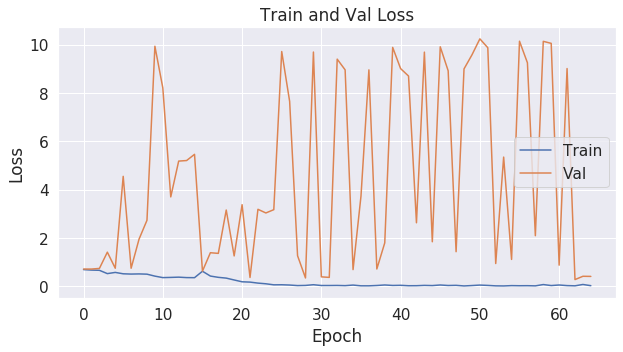

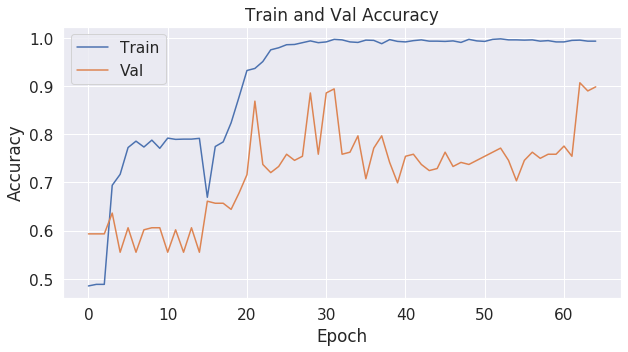

In [18]:
model = MultiCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders, dataset_sizes,
                       num_epochs=50, batch_size = batch_size)

In [19]:
running_loss = 0.0
running_corrects = 0
for inputs, labels in tqdm(dataloaders['test'], total = dataset_sizes['test']//32+1):
    labels = labels.to(device)
    inputs = [i.to(device, dtype = torch.float) for i in inputs]

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)


    running_loss += loss.item() * 32
    running_corrects += torch.sum(preds == labels.data)
    
print(f"Test Loss: {running_loss / dataset_sizes['test']}\nTest Accuracy: {running_corrects.double() / dataset_sizes['test']}")



Test Loss: 0.25597191661722046
Test Accuracy: 0.9198312236286919


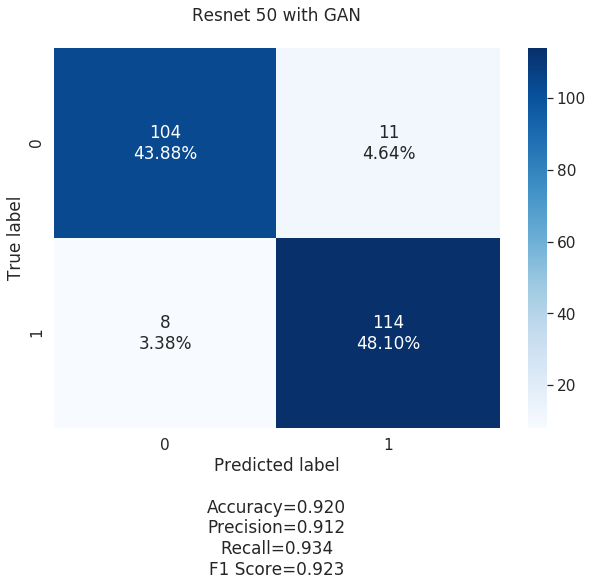

In [20]:
from confusionmatrix import make_confusion_matrix

nb_classes = 2
cf = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        classes = classes.to(device)
        inputs = [i.to(device, dtype=torch.float) for i in inputs]
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for t, p in zip(classes.view(-1), preds.view(-1)):
            cf[t.long(), p.long()] += 1

cf = np.array(cf)

group_names = ['bruh','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf.reshape(-1)/cf.sum()]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

make_confusion_matrix(cf, group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize= (10,7),
                          cmap='Blues',
                          title='Resnet 50 with GAN\n')